In [3]:
import pandas as pd

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/YangKoreec/hypertension/refs/heads/main/hypertension_dataset.csv')

HTTPError: HTTP Error 404: Not Found

Первичное исследование данных

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1985 entries, 0 to 1984
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               1985 non-null   int64  
 1   Salt_Intake       1985 non-null   float64
 2   Stress_Score      1985 non-null   int64  
 3   BP_History        1985 non-null   object 
 4   Sleep_Duration    1985 non-null   float64
 5   BMI               1985 non-null   float64
 6   Medication        1186 non-null   object 
 7   Family_History    1985 non-null   object 
 8   Exercise_Level    1985 non-null   object 
 9   Smoking_Status    1985 non-null   object 
 10  Has_Hypertension  1985 non-null   object 
dtypes: float64(3), int64(2), object(6)
memory usage: 170.7+ KB


In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,1985.0,50.341058,19.442042,18.0,34.0,50.0,67.0,84.0
Salt_Intake,1985.0,8.531688,1.994907,2.5,7.2,8.5,9.9,16.4
Stress_Score,1985.0,4.979345,3.142303,0.0,2.0,5.0,8.0,10.0
Sleep_Duration,1985.0,6.452242,1.542207,1.5,5.4,6.5,7.5,11.4
BMI,1985.0,26.015315,4.512857,11.9,23.0,25.9,29.1,41.9


In [ ]:
print(df.isnull().sum())

Age                   0
Salt_Intake           0
Stress_Score          0
BP_History            0
Sleep_Duration        0
BMI                   0
Medication          799
Family_History        0
Exercise_Level        0
Smoking_Status        0
Has_Hypertension      0
dtype: int64


In [ ]:
df['Medication'] = df['Medication'].fillna('Nothing')

In [ ]:
print(df.isnull().sum())

Age                 0
Salt_Intake         0
Stress_Score        0
BP_History          0
Sleep_Duration      0
BMI                 0
Medication          0
Family_History      0
Exercise_Level      0
Smoking_Status      0
Has_Hypertension    0
dtype: int64


In [ ]:
print(df.duplicated().sum())

0


Обработка данных

In [ ]:
# Функция для поиска выбросов в данных c помощью интервального размаха (IQR)
# data - объект Series, в котором ищутся выбросы
# Функция возвращает маску для выделения выбросов
def find_outliers_IQR(data : pd.Series) -> pd.Series:
  q1 = data.quantile(0.25) # Вычисление первого квартиля
  q3 = data.quantile(0.75) # Вычисление третьего квартиля

  # Вычисление межкварталоьного размаха
  iqr = q3 - q1

  # Создание маски для выделения выбросов
  outliers = (data < (q1 - 1.5 * iqr)) | (data > (q3 + 1.5 * iqr))

  return outliers

In [ ]:
# Создание списка всех числовых столбцов
numeric_columns = list(df.select_dtypes(include=['int', 'float']).columns)

In [ ]:
print(numeric_columns)

['Age', 'Salt_Intake', 'Stress_Score', 'Sleep_Duration', 'BMI']


In [ ]:
# Создание пустой маски для сохранения общего результата
all_outliers = df['Age'] == None

for i in numeric_columns:
  # Объединение масок по числовым столбцам в одну маску
  all_outliers = all_outliers | find_outliers_IQR(df[i])

# Вывод общего числа выбросов
print(all_outliers.sum())

44


In [ ]:
data = df[~all_outliers].copy()
data.index = range(0, df.shape[0] - all_outliers.sum())

In [ ]:
two_cat = ['Family_History', 'Smoking_Status', 'Has_Hypertension']
many_cat = ['BP_History', 'Medication', 'Exercise_Level']

In [ ]:
columns_encodings = {
    'Family_History': {'Yes': 1, 'No': 0},
    'Smoking_Status': {'Smoker': 1, 'Non-Smoker': 0},
    'Has_Hypertension': {'Yes': 1, 'No': 0}
}

In [ ]:
for column in columns_encodings:
  data[column] = data[column].map(columns_encodings[column]).astype('int')

In [ ]:
data = pd.get_dummies(data, columns=many_cat, dtype='int')

In [ ]:
print(abs(data.corr()['Has_Hypertension']).sort_values(ascending=False)[1:].to_string())

BP_History_Hypertension       0.520605
Family_History                0.278147
BP_History_Normal             0.267472
Smoking_Status                0.253804
BP_History_Prehypertension    0.225742
Age                           0.215257
Stress_Score                  0.189733
BMI                           0.139017
Sleep_Duration                0.115017
Salt_Intake                   0.110523
Medication_Diuretic           0.035736
Exercise_Level_Low            0.029457
Exercise_Level_High           0.025757
Medication_ACE Inhibitor      0.017845
Medication_Nothing            0.010980
Exercise_Level_Moderate       0.009568
Medication_Other              0.004439
Medication_Beta Blocker       0.003665


In [ ]:
best_signs = numeric_columns + ['Family_History', 'BP_History_Normal', 'Smoking_Status']

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

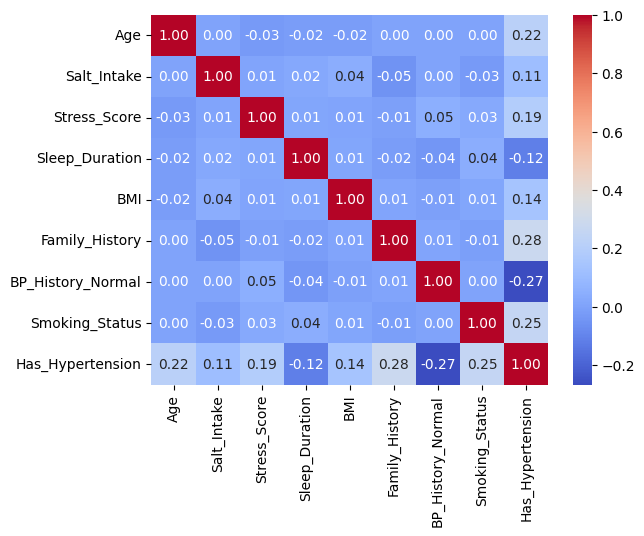

In [ ]:
sns.heatmap(data[best_signs + ['Has_Hypertension']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [2]:
x1 = 1
x2 = 0
print(x1**2 + 4*x2*x2 - 6*x1 - 8*x2 + 13)

8


Выгрузка данных

In [ ]:
for column in ['Salt_Intake', 'Sleep_Duration', 'BMI']:
  temp_mean = data[column].mean()
  temp_std = data[column].std()
  data[column] = (data[column] - temp_mean) / temp_std
  print(f"{column:<15}: mean = {round(temp_mean, 4):<7} std = {round(temp_std, 4):<5}")

Salt_Intake    : mean = 8.5274  std = 1.9233
Sleep_Duration : mean = 6.4605  std = 1.5088
BMI            : mean = 26.0528 std = 4.3682


In [ ]:
data['Stress_Score'] = data['Stress_Score'] / 10

In [ ]:
max_age = data['Age'].max()
min_age = data['Age'].min()
data['Age'] = (data['Age'] - min_age) / (max_age - min_age)
print(f"min: {min_age}\nmax: {max_age}")

min: 18
max: 84


In [ ]:
data[best_signs + ['Has_Hypertension']].to_csv('processed_data.csv', index=False)